# Stock Portfolio for Brazilian Market using ML

In this project, a machine learning classifier will be used to select the best stocks in the Brazilian stock market based on fundamental analysis of companies (Balance Sheet). Our goal is to create a model that can be used to determine whether a stock should be bought, sold or held based on the companies quarterly reports, this sort of task is extremely difficult due the complexity and randomness of the market. At the end the indicated portfolio throughout the quarters of 2021 will be compared to the IBOV index for analysis.

The dataset was downloaded from https://www.fundamentus.com.br/

The project consists in:
* Acquiring dataset
* Preprocessing the data
* EDA for feature selection
* Model selection and evaluation
* Determine 2021 quarters portfolio and it scores.

### Fundamental Analysis

Fundamental analysis of companies is based on the analysis of the balance sheet to assess the performance of companies throughout the year. However, we do not have all the knowledge of an economist to carry out in-depth analysis, but with machine learning tools we will use this data to train our model to select the best stock portfolio. That will be done using the following strategy:

* Based on how much the values of these financial information changes (%) from the previous report to the currently.
* And the stocks price change (%) from the currently to the next quarter.
* Based on the present and previous reports we determine if we should buy, sell or hold a stock.

That is, based on the performace of the quarters reports we classify if the stock are worth investing in for the current quarter.

#### Imports

In [6]:
import os
import pickle as pk

#Web scraping
import pandas_datareader as web

#Data Analysis and manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization Imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Machine Learning Models and tools
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score

In [7]:
import warnings
warnings.filterwarnings('ignore')

#### Downloading B3 Portifolio, Companies Balance Sheet, Stock Price History and IBOV index.

The first step on this project is to download the ibovespa B3 stock portifolio in excel.

https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/indice-ibovespa-ibovespa-composicao-da-carteira.htm

Them all the companies names will be stored in a list. We can check all comapnies listed bellow.

In [107]:
IBOV_list = []
for name in pd.read_csv('IBOV.csv', header=None).values.tolist():
    IBOV_list.append(name[0])
IBOV_list_bkup = IBOV_list.copy()
print(IBOV_list)

['ALPA4', 'ABEV3', 'AMER3', 'ASAI3', 'AZUL4', 'B3SA3', 'BIDI4', 'BIDI11', 'BPAN4', 'BBSE3', 'BRML3', 'BBDC3', 'BBDC4', 'BRAP4', 'BBAS3', 'BRKM5', 'BRFS3', 'BPAC11', 'CRFB3', 'CCRO3', 'CMIG4', 'CIEL3', 'COGN3', 'CPLE6', 'CSAN3', 'CPFE3', 'CVCB3', 'CYRE3', 'DXCO3', 'ECOR3', 'ELET3', 'ELET6', 'EMBR3', 'ENBR3', 'ENGI11', 'ENEV3', 'EGIE3', 'EQTL3', 'EZTC3', 'FLRY3', 'GGBR4', 'GOAU4', 'GETT11', 'GOLL4', 'NTCO3', 'SOMA3', 'HAPV3', 'HYPE3', 'IGTI11', 'GNDI3', 'IRBR3', 'ITSA4', 'ITUB4', 'JBSS3', 'JHSF3', 'KLBN11', 'RENT3', 'LCAM3', 'LWSA3', 'LAME4', 'LREN3', 'MGLU3', 'MRFG3', 'CASH3', 'BEEF3', 'MRVE3', 'MULT3', 'PCAR3', 'PETR3', 'PETR4', 'PRIO3', 'PETZ3', 'QUAL3', 'RADL3', 'RDOR3', 'RAIL3', 'SBSP3', 'SANB11', 'CSNA3', 'SULA11', 'SUZB3', 'TAEE11', 'VIVT3', 'TIMS3', 'TOTS3', 'UGPA3', 'USIM5', 'VALE3', 'VIIA3', 'VBBR3', 'WEGE3', 'YDUQ3']


All reports provide two tabs, balance sheet and profit and loss statement. We should merge them and store it as dictionary as pandas data frame for future processing.

In [ ]:
# stats_base = {}
for file in os.listdir('balancos'):
    name = file[:-4]
    
    balanco = pd.read_excel('balancos\\'+file, sheet_name=0)
    balanco.iloc[0,0] = name
    balanco.columns = balanco.iloc[0]
    balanco = balanco[1:]
    balanco = balanco.set_index(name)
    
    dre = pd.read_excel('balancos\\'+file, sheet_name=1)
    dre.iloc[0,0] = name
    dre.columns = dre.iloc[0]
    dre = dre[1:]
    dre = dre.set_index(name)
    
    frame = balanco.append(dre)
    frame.columns = pd.to_datetime(frame.columns, format='%d/%m/%Y')
    stats_base[name] = frame
    

In [109]:
display(stats_base["EGIE3"])

,2021-09-30,2021-06-30,2021-03-31,2020-12-31,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,...,2013-09-30,2013-06-30,2013-03-31,2012-12-31,2012-09-30,2012-06-30,2012-03-31,2011-12-31,2011-09-30,2011-06-30
EGIE3,,,,,,,,,,,,,,,,,,,,,
Ativo Total,38840664.064,37828489.216,35937734.656,35186249.728,34397622.272,32193656.832,31399198.72,30135578.624,27904720.896,27577403.392,...,12150960.128,12204070.912,12127365.12,12264416.256,11626718.208,11658793.984,12258426.88,12371221.504,12783889.408,12197897.216
Ativo Circulante,8598379.52,8718941.184,7291161.088,7733297.152,9135346.688,8108917.248,7305287.168,6745671.168,4474457.088,4018821.12,...,1788689.024,1872162.944,1867584,1985304.96,1278392.96,1232514.048,1531979.008,1612706.048,1943859.968,1314913.024
Caixa e Equivalentes de Caixa,4639451.136,5074016.256,4314021.888,4538946.048,5696689.152,4799481.856,4188049.92,3870260.992,1719426.048,1642322.944,...,765299.968,985329.024,815302.016,1179975.936,423336,482943.008,645076.992,781808,1127572.992,542494.016
Aplicações Financeiras,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Contas a Receber,1289531.008,1265460.992,1506535.936,1755601.024,1682402.944,1465911.04,1479169.024,1451227.008,1512131.968,1336032,...,759659.008,614812.032,783172.992,622915.968,674976,565321.024,595342.976,542148.992,534577.984,523016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IR Diferido,-185540,83586,-67401,-122424.016,-54542,-151272.992,-149828,-4295.992,-169947.008,-19210,...,45015,-1313,-7635,13950,17106,-54211,3629,-25996,-1612,-119
Participações/Contribuições Estatutárias,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reversão dos Juros sobre Capital Próprio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The stock history can be downloaded in Yahoo Finance using pandas datareader. Or loaded from the files in this notebook.

In [110]:
# stock_prices = {}
# for name in IBOV_list:
#     stock_prices2[name] = web.DataReader(name+'.SA', data_source='yahoo', start='01-01-2010')
#     print(name)

# with open(os.path.join(os.getcwd(), 'stocks_price'),'wb') as f:
#     pk.dump(stock_prices, f, pk.HIGHEST_PROTOCOL)

with open(os.path.join(os.getcwd(), 'stocks_price'), 'rb') as f:
    stock_prices = pk.load(f)
display(stock_prices["EGIE3"].tail())

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-11-26,39.070000,38.669998,38.750000,39.000000,737900.0,39.000000
2021-11-29,39.340000,38.680000,39.119999,38.860001,937900.0,38.860001
2021-11-30,38.990002,38.270000,38.799999,38.529999,2740300.0,38.529999
2021-12-01,39.189999,38.209999,38.630001,38.369999,1556900.0,38.369999
2021-12-02,39.880001,38.509998,38.750000,39.209999,1581800.0,39.209999


The Brazilian stock exchange index IBOV can also be downloaded from yahoo finances.

In [111]:
# BVSP = web.DataReader('^BVSP', data_source='yahoo', start='01-01-2010')

# with open(os.path.join(os.getcwd(), 'BVSP'),'wb') as f:
    # pk.dump(BVSP, f, pk.HIGHEST_PROTOCOL)

with open(os.path.join(os.getcwd(), 'BVSP'), 'rb') as f:
    BVSP = pk.load(f)
display(BVSP.tail())

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-11-29,104149.0,102226.0,102227.0,102814.0,10283300.0,102814.0
2021-11-30,103066.0,100075.0,102814.0,101915.0,18195100.0,101915.0
2021-12-01,104087.0,100727.0,101916.0,100775.0,13762900.0,100775.0
2021-12-02,104466.0,100785.0,100785.0,104466.0,14846500.0,104466.0
2021-12-03,104466.0,104466.0,104466.0,104466.0,14581500.0,104466.0


#### Data Preprocessing
##### Cleaning and Formatting

We should check for missing reports or corrupted ones and remove those companies from our main list IBOV_list created before.

In [112]:
NOT_IN_STATS = []
for name in IBOV_list:
    if name not in list(stats_base.keys()):
        NOT_IN_STATS.append(name)
        IBOV_list.remove(name)
        
print('Missing reports: ')
print(NOT_IN_STATS)

Missing reports: 
['GETT11', 'IRBR3']


As we did, we should look for missing or corrupt stock history and remove companies that don't match the dates. 

In [113]:
who = []
for name in list(stock_prices.keys()):
    if stock_prices[name].isnull().values.any():
        IBOV_list.remove(name)
        stock_prices.pop(name)
        who.append(name)
print(who)

[]


Along this project we will need all the companies stock prices to determine wheter we shoul buy, hold or sell. As we have seen in company balance sheets, the dates used to report are quarterly on the last days of months 30 and 31. On these dates there may often be holidays and the stock market usually does not open, with this we have to ensure that the corresponding dates in the history of the stocks are the same as those contained in the balance sheets. Let's check the dates that are present in the balance sheets and that are missing in the history of the shares and fill them in with the latest stock exchange values close to those dates.

In [114]:
stock_prices_c = {}
for name in IBOV_list:
    frame = stock_prices[name]
    
    for date in stats_base[name].columns:
        if date not in frame.index:
            frame.loc[date] = np.nan
    frame = frame.sort_index()
    frame = frame.ffill()
    
    stock_prices_c[name] = frame

In [115]:
stock_prices_c["EGIE3"].tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-11-26,39.070000,38.669998,38.750000,39.000000,737900.0,39.000000
2021-11-29,39.340000,38.680000,39.119999,38.860001,937900.0,38.860001
2021-11-30,38.990002,38.270000,38.799999,38.529999,2740300.0,38.529999
2021-12-01,39.189999,38.209999,38.630001,38.369999,1556900.0,38.369999
2021-12-02,39.880001,38.509998,38.750000,39.209999,1581800.0,39.209999


As we can see the stock history cointains information as Open, Close, Volume and Adjusted Close. For us the most important information here is the Adjusted Close which represents a stock's closing price that reflect that stock's value after accounting for any corporate actions at the day.
We are select the "Adj Close" column and merge by dates with the balance sheet as one data frame. Also we are changing index with columns for future training.

In [117]:
stats_base_c = {}
aux2 = []
for name in IBOV_list:
    aux = stats_base[name].T
    
    frame2 = aux.merge(stock_prices_c[name][["Adj Close"]], left_index=True, right_index=True)
    frame2 = frame2[frame2["Adj Close"].notna()]
    
    frame2.index.name = name
    
    if frame2.shape[0] != 0:
        stats_base_c[name] = frame2
    else:
        aux2.append(name)

for name in aux2:
    IBOV_list.remove(name)

display(stats_base_c["EGIE3"].tail())

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber,Estoques,Ativos Biológicos,Tributos a Recuperar,Despesas Antecipadas,Outros Ativos Circulantes,...,Receitas,Despesas,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Participações/Contribuições Estatutárias,Reversão dos Juros sobre Capital Próprio,Part. de Acionistas Não Controladores,Lucro/Prejuízo do Período,Adj Close
EGIE3,,,,,,,,,,,,,,,,,,,,,
2012-06-30,11658793.984,1232514.048,482943.008,0,565321.024,46910,0,66525,0,70815,...,NaN,NaN,513683.008,-115120,-54211,NaN,NaN,-126,344225.984,16.035315
2012-03-31,12258426.88,1531979.008,645076.992,0,595342.976,49281,0,153495.008,0,88783,...,NaN,NaN,494508,-168615.008,3629,NaN,NaN,-143,329379.008,13.954075
2011-12-31,12371221.504,1612706.048,781808,0,542148.992,42837,0,150792,0,95120,...,NaN,NaN,548980.992,-72886.016,-25996,NaN,NaN,-470,449628.96,12.777020
2011-09-30,12783889.408,1943859.968,1127572.992,0,534577.984,47320,0,140650,0,93739,...,NaN,NaN,494892,-161000.992,-1612,NaN,NaN,0,332279.008,10.978183
2011-06-30,12197897.216,1314913.024,542494.016,0,523016,43217,0,108476,0,97710,...,NaN,NaN,525465.984,-166572.992,-119,NaN,NaN,0,358774.016,11.111565


B3's portfolio has several companies from many different industries, which means that each industry has different fundamentals. For example, a logistics company has stocks, but a bank does not, with this the first filter to be applied to the data sets is the exclusion of balance sheet features that are not common to all companies. And exclude companies where the balance is very different.

In [118]:
features = list(stats_base_c["ABEV3"].columns)
who = []
for name in stats_base_c.keys():
    if set(features) != set(stats_base_c[name].columns):
        IBOV_list.remove(name)
        who.append(name)
print(who)
print(len(IBOV_list))
for name in who:
    stats_base_c.pop(name)

['BIDI4', 'BIDI11', 'BPAN4', 'BBDC3', 'BBDC4', 'BBAS3', 'BPAC11', 'ITUB4', 'SANB11']
80


We found out that most banks does not mach with most commom features for companies.
As we merged cash flow and balance sheet of companies we also found duplicated columns, but these columns does not have the same propreties and does not share the same information.

In [119]:
print(stats_base_c["EGIE3"].columns)

Index(['Ativo Total', 'Ativo Circulante', 'Caixa e Equivalentes de Caixa',
       'Aplicações Financeiras', 'Contas a Receber', 'Estoques',
       'Ativos Biológicos', 'Tributos a Recuperar', 'Despesas Antecipadas',
       'Outros Ativos Circulantes', 'Ativo Realizável a Longo Prazo',
       'Aplicações Financeiras Avaliadas a Valor Justo',
       'Aplicações Financeiras Avaliadas ao Custo Amortizado',
       'Contas a Receber', 'Estoques', 'Ativos Biológicos',
       'Tributos Diferidos', 'Despesas Antecipadas',
       'Créditos com Partes Relacionadas', 'Outros Ativos Não Circulantes',
       'Investimentos', 'Imobilizado', 'Intangível', 'Diferido',
       'Passivo Total', 'Passivo Circulante',
       'Obrigações Sociais e Trabalhistas', 'Fornecedores',
       'Obrigações Fiscais', 'Empréstimos e Financiamentos',
       'Passivos com Partes Relacionadas', 'Dividendos e JCP a Pagar',
       'Outros', 'Provisões',
       'Passivos sobre Ativos Não-Correntes a Venda e Descontinuados',
 

To solve these problem we will change the name of those features so we can have different features.

In [120]:
txt_features = ";".join(features)
features_mod = []
for feature in features:
    if features.count(feature) == 2 and feature not in features_mod:
        txt_features = txt_features.replace(';'+feature+';', ';'+feature+'_1;',1)
        features_mod.append(feature)
txt_features = txt_features.split(';')
print(txt_features)

['Ativo Total', 'Ativo Circulante', 'Caixa e Equivalentes de Caixa', 'Aplicações Financeiras', 'Contas a Receber_1', 'Estoques_1', 'Ativos Biológicos_1', 'Tributos a Recuperar', 'Despesas Antecipadas_1', 'Outros Ativos Circulantes', 'Ativo Realizável a Longo Prazo', 'Aplicações Financeiras Avaliadas a Valor Justo', 'Aplicações Financeiras Avaliadas ao Custo Amortizado', 'Contas a Receber', 'Estoques', 'Ativos Biológicos', 'Tributos Diferidos_1', 'Despesas Antecipadas', 'Créditos com Partes Relacionadas', 'Outros Ativos Não Circulantes', 'Investimentos', 'Imobilizado', 'Intangível', 'Diferido', 'Passivo Total', 'Passivo Circulante', 'Obrigações Sociais e Trabalhistas', 'Fornecedores', 'Obrigações Fiscais', 'Empréstimos e Financiamentos_1', 'Passivos com Partes Relacionadas_1', 'Dividendos e JCP a Pagar', 'Outros_1', 'Provisões_1', 'Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1', 'Passivo Não Circulante', 'Empréstimos e Financiamentos', 'Passivos com Partes Relacionadas'

Now we change the columns names in our database

In [121]:
for name in IBOV_list:
    stats_base_c[name].columns = txt_features

As we can see below the are several null values or nan values in the balance sheet.

In [122]:
display(stats_base_c["EGIE3"].tail())

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,...,Receitas,Despesas,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Participações/Contribuições Estatutárias,Reversão dos Juros sobre Capital Próprio,Part. de Acionistas Não Controladores,Lucro/Prejuízo do Período,Adj Close
EGIE3,,,,,,,,,,,,,,,,,,,,,
2012-06-30,11658793.984,1232514.048,482943.008,0,565321.024,46910,0,66525,0,70815,...,NaN,NaN,513683.008,-115120,-54211,NaN,NaN,-126,344225.984,16.035315
2012-03-31,12258426.88,1531979.008,645076.992,0,595342.976,49281,0,153495.008,0,88783,...,NaN,NaN,494508,-168615.008,3629,NaN,NaN,-143,329379.008,13.954075
2011-12-31,12371221.504,1612706.048,781808,0,542148.992,42837,0,150792,0,95120,...,NaN,NaN,548980.992,-72886.016,-25996,NaN,NaN,-470,449628.96,12.777020
2011-09-30,12783889.408,1943859.968,1127572.992,0,534577.984,47320,0,140650,0,93739,...,NaN,NaN,494892,-161000.992,-1612,NaN,NaN,0,332279.008,10.978183
2011-06-30,12197897.216,1314913.024,542494.016,0,523016,43217,0,108476,0,97710,...,NaN,NaN,525465.984,-166572.992,-119,NaN,NaN,0,358774.016,11.111565


We need to process all these values. Our strategy to work around that is to check the sum of all null values from all companies balance sheets. We will identify the most columns that contains several null values and exclude them from our data base.

In [123]:
null_count  = dict.fromkeys(txt_features,0)
overall_row = 0

for name in IBOV_list:
    overall_row += stats_base_c[name].shape[0]
    for feature in stats_base_c[name].columns:
        null = pd.isnull(stats_base_c[name][feature]).sum()
        null_count[feature] += null
print(null_count)
print(overall_row)

{'Ativo Total': 2, 'Ativo Circulante': 2, 'Caixa e Equivalentes de Caixa': 2, 'Aplicações Financeiras': 2, 'Contas a Receber_1': 2, 'Estoques_1': 2, 'Ativos Biológicos_1': 2, 'Tributos a Recuperar': 2, 'Despesas Antecipadas_1': 2, 'Outros Ativos Circulantes': 2, 'Ativo Realizável a Longo Prazo': 2, 'Aplicações Financeiras Avaliadas a Valor Justo': 2, 'Aplicações Financeiras Avaliadas ao Custo Amortizado': 2, 'Contas a Receber': 2, 'Estoques': 2, 'Ativos Biológicos': 2, 'Tributos Diferidos_1': 2, 'Despesas Antecipadas': 2, 'Créditos com Partes Relacionadas': 2, 'Outros Ativos Não Circulantes': 2, 'Investimentos': 2, 'Imobilizado': 2, 'Intangível': 2, 'Diferido': 2, 'Passivo Total': 2, 'Passivo Circulante': 2, 'Obrigações Sociais e Trabalhistas': 2, 'Fornecedores': 2, 'Obrigações Fiscais': 2, 'Empréstimos e Financiamentos_1': 2, 'Passivos com Partes Relacionadas_1': 2, 'Dividendos e JCP a Pagar': 2, 'Outros_1': 2, 'Provisões_1': 2, 'Passivos sobre Ativos Não-Correntes a Venda e Descontin

We chose as cut point 50 null values, the columns to be excluded are listed below.

In [124]:
features_to_remove = []
for feature in null_count:
    if null_count[feature] >= 50:
        features_to_remove.append(feature)
print(features_to_remove)

['Receita Bruta de Vendas e/ou Serviços', 'Deduções da Receita Bruta', 'Resultado Não Operacional', 'Receitas', 'Despesas', 'Participações/Contribuições Estatutárias', 'Reversão dos Juros sobre Capital Próprio', 'Part. de Acionistas Não Controladores']


In [126]:
for name in IBOV_list:
    stats_base_c[name] = stats_base_c[name].drop(features_to_remove, axis=1)
    stats_base_c[name] = stats_base_c[name].ffill()

We also chose to apply another filter in ou data base, we chose to exclude the companies that has less than 5 years in the stock market beyond the 2021 year that we will select our portifolio.

In [128]:
years_in_maket = 5

who_drop = []
for name in IBOV_list:
    if stats_base_c[name].shape[0] < (3 + (years_in_maket*4)):
        who_drop.append(name)
print(who_drop)
print(len(who_drop))
print(len(IBOV_list))

['ASAI3', 'AZUL4', 'BBSE3', 'CRFB3', 'NTCO3', 'SOMA3', 'HAPV3', 'GNDI3', 'LWSA3', 'CASH3', 'PETZ3', 'RDOR3', 'TIMS3', 'VBBR3']
14
80


As we can see we are not losing so many companies so we proceed to exclude those companies.

In [129]:
for name in who_drop:
    stats_base_c.pop(name)
    IBOV_list.remove(name)

The IBOV index is exactly as stocks history, but the Adj Close is not a price but a score, and we will use it as we did with the stocks. We have to merge the IBOV index in our dataset as we did before.

In [130]:
for data in stats_base_c["ABEV3"].index:
    if data not in BVSP.index:
        BVSP.loc[data] = np.nan
BVSP = BVSP.sort_index().ffill()
BVSP = BVSP.rename(columns={"Adj Close": "IBOV"})

for name in IBOV_list:
    stats_base_c[name] = stats_base_c[name].merge(BVSP[["IBOV"]], left_index=True, right_index=True)

In [131]:
display(stats_base_c["EGIE3"].tail())

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,...,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Adj Close,IBOV
2013-06-30,1.220407e+07,1872162.944,985329.024,0,614812.032,61925.0,0,59880.0,0,150216.992,...,0.0,-91826.000,50958.0,-142784.000,483092.000,-157764.992,-1313.0,323864.992,16.007711,47457.0
2013-03-31,1.212737e+07,1867584.000,815302.016,0,783172.992,54120.0,0,65895.0,0,149094.000,...,0.0,-98492.000,24515.0,-123007.000,630889.024,-198376.992,-7635.0,424712.000,15.956922,56352.0
2012-12-31,1.226442e+07,1985304.960,1179975.936,0,622915.968,45374.0,0,64749.0,0,72290.000,...,0.0,-107486.016,18923.0,-126408.992,505808.992,-86031.968,13950.0,433715.968,15.011609,60952.0
2011-09-30,1.278389e+07,1943859.968,1127572.992,0,534577.984,47320.0,0,140650.0,0,93739.000,...,0.0,-101401.000,29835.0,-131236.000,494892.000,-161000.992,-1612.0,332279.008,10.978183,52324.0
2011-06-30,1.219790e+07,1314913.024,542494.016,0,523016.000,43217.0,0,108476.0,0,97710.000,...,0.0,-79376.000,22561.0,-101937.000,525465.984,-166572.992,-119.0,358774.016,11.111565,62404.0


In this step we will do two things together, first we will calculate the percentage changes of all the characteristics of the balance sheet of companies. This variation is limited to 100% or -100%, that is, if a company grows for example 150% from one quarter to another, the variation will be limited to 100%. The other step is to determine when to buy the stock as follows.

* If the stock has performed better than the stock market, appreciates more or depreciates less, we buy. Label 2.
* If the stock has performed worse than the stock market but even the same variation, appreciates less or depreciates more, we don't buy. Label 1.
* If the stock has performed worse than the stock market, appreciates less or depreciates more, we sell. Label 0.

These decisions are based on the cutoff value that serves as the basis for the model's decision.

In [132]:
cut_point = 0.02
for name in stats_base_c:
    aux = stats_base_c[name]
    aux = aux.sort_index()
    for col in stats_base_c[name]:
        if "Adj Close" in col or "IBOV" in col:
            pass
        
        else:
            condition = [(aux[col].shift(1) > 0) & (aux[col] < 0),
                         (aux[col].shift(1) < 0) & (aux[col] > 0),
                         (aux[col].shift(1) < 0) & (aux[col] < 0),
                         (aux[col].shift(1) == 0) & (aux[col] > 0),
                         (aux[col].shift(1) == 0) & (aux[col] < 0),
                         (aux[col].shift(1) < 0) & (aux[col] == 0)]
            values = [-1,
                      1,
                      (aux[col].shift(1) - abs(aux[col])) / abs(aux[col].shift(1)),
                      1,
                      -1,
                      1]
            
            aux[col] = np.select(condition, values, default=aux[col] / aux[col].shift(1) - 1)
            
    aux["Adj Close"] = (aux["Adj Close"].shift(-1) / aux["Adj Close"]) - 1
    aux["IBOV"] = (aux["IBOV"].shift(-1) / aux["IBOV"]) - 1
    aux["Resultados"] = aux["Adj Close"] - aux["IBOV"]
    
    condition = [(aux["Resultados"] > 0),
                (aux["Resultados"] < 0) & (aux["Resultados"] >= - cut_point),
                (aux["Resultados"] < -cut_point)]
                
    decision = [2, 1, 0]
    aux["Decisao"] = np.select(condition, decision)
    
    stats_base_c[name] = aux

Let's check how our data was after processing. 

In [133]:
display(stats_base_c["EGIE3"].tail())

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,...,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Adj Close,IBOV,Resultados,Decisao
2020-09-30,0.068460,0.126580,0.186938,NaN,0.147684,-0.096207,NaN,0.235629,NaN,-0.072839,...,-0.429813,-3.368565,-0.407603,-1.580874,-1.360553,-0.360454,0.105703,0.261123,-0.155420,0
2020-12-31,0.022927,-0.153475,-0.203231,NaN,0.043508,-0.206634,NaN,-0.339165,NaN,-0.150188,...,-0.426546,-2.146151,1.199178,-3.893393,-3.244582,1.103535,-0.048020,-0.022396,-0.025624,0
2021-03-31,0.021357,-0.057173,-0.049554,NaN,-0.141869,-0.006984,NaN,-0.157993,NaN,0.049993,...,-0.314231,-2.129342,-0.497048,-1.412795,-1.550554,-0.486659,-0.045895,0.087179,-0.133073,0
2021-06-30,0.052612,0.195823,0.176168,NaN,-0.160019,-0.022456,NaN,0.025147,NaN,0.781906,...,1.543027,-1.955581,-0.443386,-2.785672,1.000000,-0.397149,0.008061,-0.124785,0.132847,2
2021-09-30,0.026757,-0.013828,-0.085645,NaN,0.019021,-0.158184,NaN,0.637525,NaN,0.116461,...,0.308121,-1.919069,1.233489,-1.104631,-1.000000,1.003526,NaN,NaN,NaN,0


The first row of the dataset will be deleted as it has null values, a result of the fact that there is no previous quarter to calculate the variation.

The next step is to perform the same procedure as before and delete the columns that have many unknown values and fill the missing values with zero.

In [134]:
features = stats_base_c["ABEV3"].columns
null_count  = dict.fromkeys(features,0)
overall_row = 0

for name in IBOV_list:
    overall_row += stats_base_c[name].shape[0]
    for feature in stats_base_c[name].columns:
        null = pd.isnull(stats_base_c[name][feature]).sum()
        null_count[feature] += null
        
print(null_count)
print(overall_row)

{'Ativo Total': 66, 'Ativo Circulante': 66, 'Caixa e Equivalentes de Caixa': 66, 'Aplicações Financeiras': 739, 'Contas a Receber_1': 72, 'Estoques_1': 589, 'Ativos Biológicos_1': 2324, 'Tributos a Recuperar': 317, 'Despesas Antecipadas_1': 1369, 'Outros Ativos Circulantes': 288, 'Ativo Realizável a Longo Prazo': 67, 'Aplicações Financeiras Avaliadas a Valor Justo': 1930, 'Aplicações Financeiras Avaliadas ao Custo Amortizado': 2084, 'Contas a Receber': 1212, 'Estoques': 1689, 'Ativos Biológicos': 2206, 'Tributos Diferidos_1': 1075, 'Despesas Antecipadas': 1325, 'Créditos com Partes Relacionadas': 1627, 'Outros Ativos Não Circulantes': 621, 'Investimentos': 399, 'Imobilizado': 67, 'Intangível': 93, 'Diferido': 2477, 'Passivo Total': 66, 'Passivo Circulante': 66, 'Obrigações Sociais e Trabalhistas': 478, 'Fornecedores': 171, 'Obrigações Fiscais': 118, 'Empréstimos e Financiamentos_1': 101, 'Passivos com Partes Relacionadas_1': 1769, 'Dividendos e JCP a Pagar': 918, 'Outros_1': 128, 'Prov

Here we choose as a cutoff value 1/3 of the total value of the columns of the entire dataset. Could be any value. And we will drop the Adj Close, IBOV and Results columns because we won't use them anymore.

In [135]:
rule = overall_row / 3
features_to_drop = []
for feature in null_count:
    if null_count[feature] > rule:
        features_to_drop.append(feature)
        
for name in IBOV_list:
    stats_base_c[name] = stats_base_c[name].drop(features_to_drop, axis=1)
    stats_base_c[name] = stats_base_c[name].fillna(0)
    stats_base_c[name] = stats_base_c[name].drop(["Adj Close", "IBOV", "Resultados"], axis=1)
    stats_base_c[name] = stats_base_c[name][1:]

Before starting the exploratory analysis of the data, let's separate the quarters referring to 2021 to use them later to choose our portfolio. This includes the three quarters of 2021 and the last quarter of 2020. We will also create a backup copy of our data.

In [136]:
stats_base_c_bkp = stats_base_c.copy()
aux = dict()
base = pd.DataFrame()
for name in IBOV_list:
    aux[name] = stats_base_c[name][1:-4]
    aux[name] = stats_base_c[name].reset_index(drop=True)
    base = base.append(aux[name])

#### Exploratory Data Analisys - EDA

##### Visualising Labels

The first step in the data analysis process consists of verifying how our classes were distributed.

* 2 - Buy
* 1 - Do not buy or Hold
* 0 - Sell 

2    49.48%
0    45.17%
1     5.35%
Name: Decisao, dtype: object

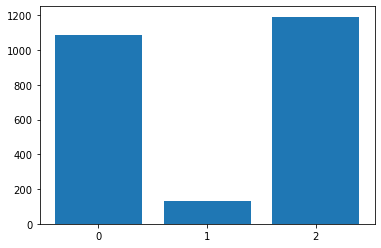

In [137]:
display(base["Decisao"].value_counts(normalize=(True)).map("{:.2%}".format))

fig = plt.figure()
frq = np.array(base["Decisao"].value_counts().sort_index())
plt.bar([0,1,2], height=frq)
plt.xticks([0,1,2], ["0", "1", "2"])
plt.show()

As we can see there is a small portion of recommendations that suggest that we do not buy the shares. As this is only 5% we will reclassify the labels 0 as 1. 

In [138]:
base.loc[base["Decisao"]==1, "Decisao"] = 0
display(base["Decisao"].value_counts(normalize=(True)).map("{:.2%}".format))

0    50.52%
2    49.48%
Name: Decisao, dtype: object

The next step is to analyze a correlation matrix. In our portfolio recommendation problem, we deal with several different characteristics in the balance sheet of companies, however much of the information present in the balance sheet has a high correlation, that is, it is often different information that informs the same thing. 

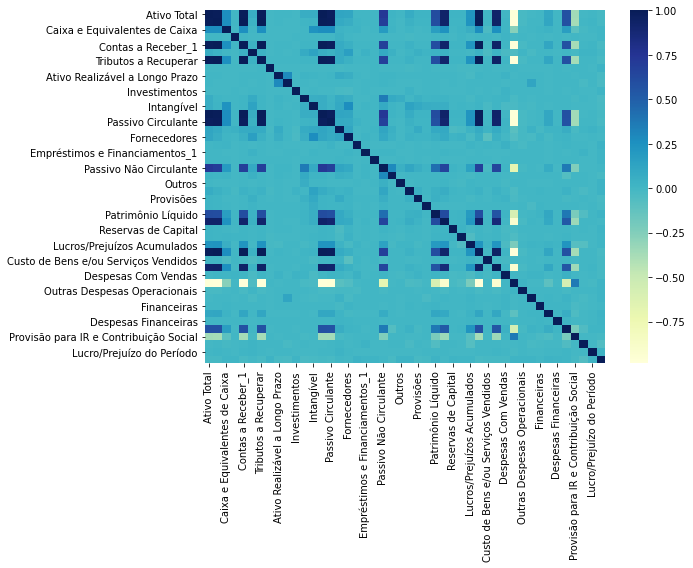

In [139]:
corr_matrix = base.corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="YlGnBu", ax=ax)
plt.tight_layout()
plt.show()

As we can see there are characteristics that have a very high correlation with total assets, for example, current assets. So, let's create a cutoff value and exclude all the features that have a value greater than our cutoff. So we exclude features that inform the same.

In [144]:
cutoff = 0.7
who = []
for col in corr_matrix:
    for row in corr_matrix.index:
        if row != col:
            corr_val = abs(corr_matrix.loc[row, col])
            if corr_val > cutoff and any(set((col, row, corr_val)) == set(s) for s in who) == False:
                who.append((row, col, corr_val))
                #print((row, col, corr_val))
          
features_to_drop = np.unique([val[0] for val in who])
print(features_to_drop)

['Ativo Circulante' 'Capital Social Realizado' 'Contas a Receber_1'
 'Despesas Gerais e Administrativas' 'Passivo Circulante'
 'Passivo Não Circulante' 'Passivo Total'
 'Receita Líquida de Vendas e/ou Serviços' 'Resultado Bruto'
 'Tributos a Recuperar']


let's remove the selected features and analyze the correlation matrix again.

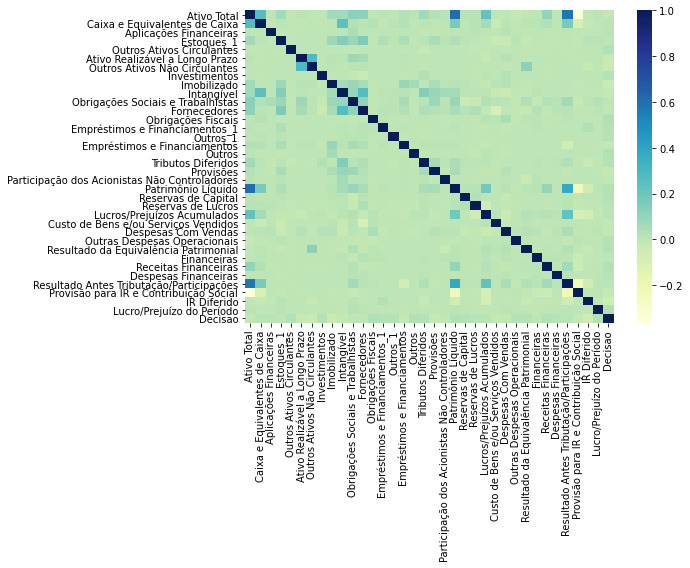

In [145]:
base = base.drop(features_to_drop, axis=1)

corr_matrix = base.corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="YlGnBu", ax=ax)
plt.tight_layout()
plt.show()

##### Feature Engineering and Feature Selection

The feature engineering and feature selection process is necessary to improve the performance of our model. To determine which features are the best for training our model, we will use the decision tree classifier from the Sci-kit Learn package because it has a feature relevance method. We could use correlation matrix too.

In [212]:
x = base.drop("Decisao", axis=1)
y = base["Decisao"]

model = ExtraTreesClassifier(random_state=1)
model.fit(x, y)

feature_frame = pd.DataFrame(model.feature_importances_, x.columns).sort_values(by=0, ascending=False)

top10 = list(feature_frame.index)[:13]
display(feature_frame[:13])

,0
Outros Ativos Circulantes,0.032546
Lucros/Prejuízos Acumulados,0.030947
Custo de Bens e/ou Serviços Vendidos,0.030864
Receitas Financeiras,0.030615
Fornecedores,0.030592
Obrigações Sociais e Trabalhistas,0.030415
IR Diferido,0.030256
Obrigações Fiscais,0.030240
Ativo Total,0.029787
Tributos Diferidos,0.029157


We chose the top 13 features importance to use for our model.

To improve the training of our model, we are going to standardize the data, for that we are going to create a function that will help us in this process. 

In [213]:
def scaler(input_frame):
    scaler = StandardScaler()
    
    aux = input_frame.drop("Decisao", axis=1)
    
    aux = pd.DataFrame(scaler.fit_transform(aux), aux.index, aux.columns)
    aux["Decisao"] = input_frame["Decisao"]
    
    return aux

base_std = scaler(base)
top10.append("Decisao")
base_std = base_std[top10]
display(top10)

['Outros Ativos Circulantes',
 'Lucros/Prejuízos Acumulados',
 'Custo de Bens e/ou Serviços Vendidos',
 'Receitas Financeiras',
 'Fornecedores',
 'Obrigações Sociais e Trabalhistas',
 'IR Diferido',
 'Obrigações Fiscais',
 'Ativo Total',
 'Tributos Diferidos',
 'Lucro/Prejuízo do Período',
 'Despesas Financeiras',
 'Outros_1',
 'Decisao']

And now separate the test and training set.

In [214]:
x = base_std.drop("Decisao", axis=1)
y = base_std["Decisao"]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
display(base_std)

,Outros Ativos Circulantes,Lucros/Prejuízos Acumulados,Custo de Bens e/ou Serviços Vendidos,Receitas Financeiras,Fornecedores,Obrigações Sociais e Trabalhistas,IR Diferido,Obrigações Fiscais,Ativo Total,Tributos Diferidos,Lucro/Prejuízo do Período,Despesas Financeiras,Outros_1,Decisao
0,-0.030848,-0.001103,-0.000665,-0.037422,0.325349,0.682872,0.098120,-0.047453,0.014036,0.015574,-0.029424,0.020620,-0.024617,2
1,-0.034436,-0.001103,-0.035741,-0.082388,0.644279,0.048588,-0.076121,-0.073359,0.063400,-0.624352,-0.030822,0.024425,-0.027149,0
2,-0.028497,-0.001103,0.039235,-0.051454,-0.064518,0.388718,0.098120,-0.011464,0.036454,-0.075765,-0.028742,0.022162,-0.029812,2
3,-0.027356,-0.001103,-0.004496,0.054381,-0.003420,-0.158104,-0.076121,-0.056325,-0.012916,-0.075765,-0.030805,0.012872,-0.021935,0
4,-0.032425,-0.001103,0.005549,-0.036187,-0.160710,0.484306,0.098120,-0.001939,0.011978,-0.075765,-0.029841,0.018955,-0.026139,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,-0.029639,0.395528,0.021207,-0.048263,-0.240634,-0.822929,-0.045636,-0.045471,-0.048573,-0.086348,-0.026750,0.022306,-0.029208,0
33,-0.029781,-0.312642,-0.016786,-0.137842,0.148458,-1.625076,0.113332,-0.038998,-0.080332,-0.092852,-0.033308,0.030575,-0.034872,0
34,-0.032984,0.310437,0.038126,0.020651,-0.028746,0.776785,-0.041232,-0.063422,-0.016660,-0.624352,-0.026750,-0.007911,-0.031961,2
35,-0.030706,0.838306,0.000114,0.022687,-0.664492,0.426370,-0.076121,-0.054793,-0.062965,-0.075765,-0.024473,0.021826,-0.007415,0


We create another function to help us, this function consists of creating a classification report to evaluate the performance of the models.

In [215]:
def evaluate(y_test, prediction, model_name):
    print(model_name)
    report = classification_report(y_test, prediction)
    
    print(report)
    
    frame = pd.DataFrame(confusion_matrix(y_test, prediction), index=["Sell", "Buy"], columns= ["Sell", "Buy"])
    fig = plt.figure()
    plt.title(model_name)
    sns.heatmap(frame, annot=True, cmap="YlGnBu", fmt=',')
    plt.show()

#### Model Selection

For the next step, we are going to choose a model among some that presents better performance according to the confusion matrix. We will create a pool of models, train them and select the best based on the profit/loss.

AdaBoost
              precision    recall  f1-score   support

           0       0.54      0.57      0.55       303
           2       0.54      0.51      0.52       300

    accuracy                           0.54       603
   macro avg       0.54      0.54      0.54       603
weighted avg       0.54      0.54      0.54       603



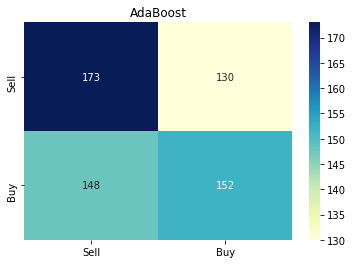

DecisionTree
              precision    recall  f1-score   support

           0       0.56      0.53      0.54       303
           2       0.55      0.58      0.56       300

    accuracy                           0.55       603
   macro avg       0.55      0.55      0.55       603
weighted avg       0.55      0.55      0.55       603



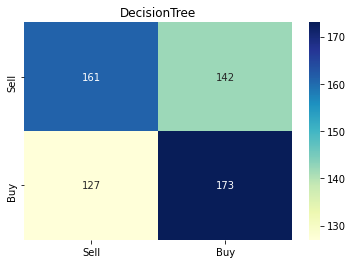

RandomForest
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       303
           2       0.56      0.52      0.54       300

    accuracy                           0.56       603
   macro avg       0.56      0.56      0.56       603
weighted avg       0.56      0.56      0.56       603



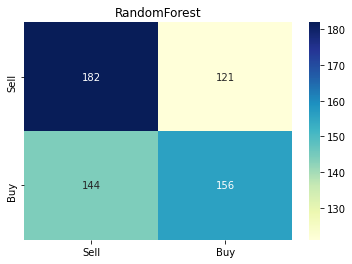

ExtraTree
              precision    recall  f1-score   support

           0       0.53      0.57      0.55       303
           2       0.53      0.49      0.51       300

    accuracy                           0.53       603
   macro avg       0.53      0.53      0.53       603
weighted avg       0.53      0.53      0.53       603



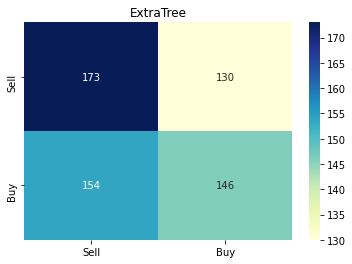

GradientBoost
              precision    recall  f1-score   support

           0       0.55      0.52      0.54       303
           2       0.54      0.56      0.55       300

    accuracy                           0.54       603
   macro avg       0.54      0.54      0.54       603
weighted avg       0.54      0.54      0.54       603



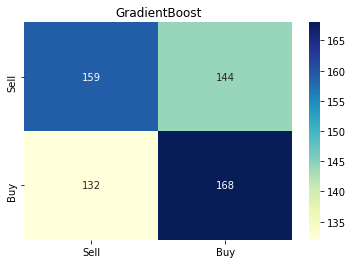

KNN
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       303
           2       0.54      0.55      0.54       300

    accuracy                           0.54       603
   macro avg       0.54      0.54      0.54       603
weighted avg       0.54      0.54      0.54       603



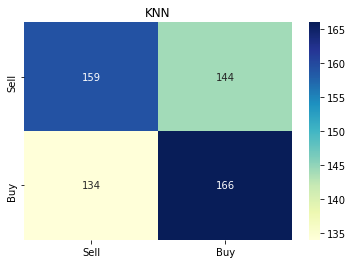

LogisticRegression
              precision    recall  f1-score   support

           0       0.52      0.74      0.61       303
           2       0.53      0.30      0.38       300

    accuracy                           0.52       603
   macro avg       0.52      0.52      0.49       603
weighted avg       0.52      0.52      0.50       603



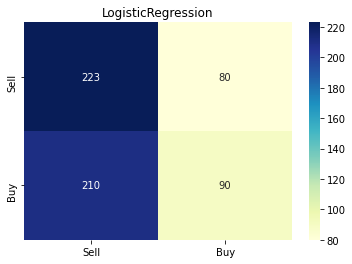

NaiveBayes
              precision    recall  f1-score   support

           0       0.50      0.92      0.64       303
           2       0.42      0.06      0.10       300

    accuracy                           0.49       603
   macro avg       0.46      0.49      0.37       603
weighted avg       0.46      0.49      0.38       603



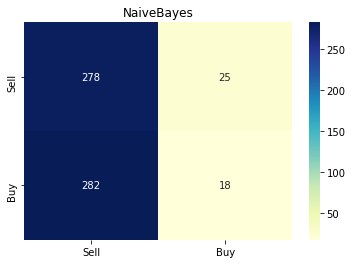

SVM
              precision    recall  f1-score   support

           0       0.51      0.86      0.64       303
           2       0.55      0.17      0.26       300

    accuracy                           0.52       603
   macro avg       0.53      0.52      0.45       603
weighted avg       0.53      0.52      0.45       603



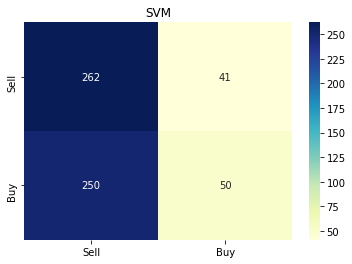

ANN
              precision    recall  f1-score   support

           0       0.53      0.53      0.53       303
           2       0.52      0.52      0.52       300

    accuracy                           0.52       603
   macro avg       0.52      0.52      0.52       603
weighted avg       0.52      0.52      0.52       603



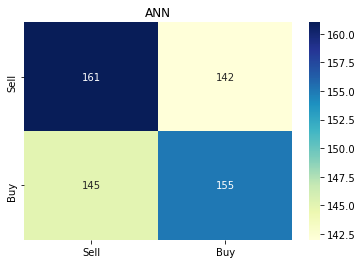

In [216]:
models = {"AdaBoost": AdaBoostClassifier(random_state=1),
            "DecisionTree": DecisionTreeClassifier(random_state=1),
            "RandomForest": RandomForestClassifier(random_state=1),
            "ExtraTree": ExtraTreesClassifier(random_state=1),
            "GradientBoost": GradientBoostingClassifier(random_state=1),
            "KNN": KNeighborsClassifier(),
            "LogisticRegression": LogisticRegression(random_state=1),
            "NaiveBayes": GaussianNB(),
            "SVM": SVC(random_state=1),
            "ANN": MLPClassifier(random_state=1, max_iter=500)
    }

for model in models:
    mod = models[model]
    mod.fit(x_train, y_train)
    pred = mod.predict(x_test)
    evaluate(y_test, pred, model)
    models[model] = mod

To choose the best model, let's evaluate the sales accuracy (label 0), if the model determines that we must sell the stock at the wrong time, we may lose money. To untie the choice of models, let's analyze the recall that indicates the ability to identify negative samples.

After selecting the random forest model, we will do a grid training with cross validation to check if the model choice was adequate.

In [217]:
n_estimators = range(10,251,30)
max_features = list(range(2,11,2))
max_features.append('auto')
min_samples_split = range(2,11,2)

precision2_score = make_scorer(precision_score, labels=[2], average="macro")


final_model = models["RandomForest"]
grid = GridSearchCV(RandomForestClassifier(),
                        param_grid = {"n_estimators":n_estimators,
                                      "max_features":max_features,
                                      "min_samples_split":min_samples_split,
                                      "random_state": [1]},
                        scoring=precision2_score)
grid_results = grid.fit(x_train, y_train)
print('done')

done


After the grid search we will select the best trained model to recommend our portfolio.

RandomForest
              precision    recall  f1-score   support

           0       0.55      0.58      0.57       303
           2       0.55      0.52      0.54       300

    accuracy                           0.55       603
   macro avg       0.55      0.55      0.55       603
weighted avg       0.55      0.55      0.55       603



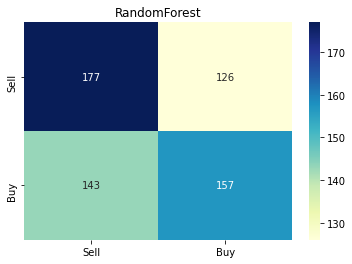

In [218]:
final_model2 = grid_results.best_estimator_
results = final_model2.predict(x_test)
evaluate(y_test, results, "RandomForest")

Indeed our model was a good choice, our results are solid. For now we are going to recreate our stardard scale function for the recommendation portifolio.

In [219]:
def scaler_f(input_frame):
    scaler = StandardScaler()
    
    aux = input_frame.drop("Name", axis=1)
    
    aux = pd.DataFrame(scaler.fit_transform(aux), aux.index, aux.columns)
    aux["Name"] = input_frame["Name"]
    
    return aux

For the recommendation and analysis of portfolio performance, we will use the last 4 quarters of our dataset, the last quarter of 2020 and the 3 quarters of 2021. We will use our stock portfolio recommendation model and analyze their performance in the following quarter. The 3rd quarter of 2021 will be analyzed based on the share price available to date.

In [220]:
top10_c = top10.copy()

base_2021 = dict()
for data in list(stats_base_c["ABEV3"].index[-4:]):
    print(data)
    temp = pd.DataFrame()
    stock_names = []
    for name in IBOV_list:
        if stats_base_c[name].shape[0] > 4:
            temp = temp.append(stats_base_c[name].loc[data])
            stock_names.append(name)
    
    temp = temp[top10_c].drop("Decisao", axis=1)
    temp["Name"] = stock_names
    
    temp = scaler_f(temp)
    base_2021[data] = temp

decision = {}
for data in base_2021:
    decision[data] = final_model2.predict(base_2021[data].drop("Name", axis=1))
for data in base_2021:
    base_2021[data]["Decisao"] = decision[data]

2020-12-31 00:00:00
2021-03-31 00:00:00
2021-06-30 00:00:00
2021-09-30 00:00:00


Let's take a look at how the recommendation table looks.

In [221]:
display(base_2021[list(stats_base_c["ABEV3"].index[-4:])[0]])

,Outros Ativos Circulantes,Lucros/Prejuízos Acumulados,Custo de Bens e/ou Serviços Vendidos,Receitas Financeiras,Fornecedores,Obrigações Sociais e Trabalhistas,IR Diferido,Obrigações Fiscais,Ativo Total,Tributos Diferidos,Lucro/Prejuízo do Período,Despesas Financeiras,Outros_1,Name,Decisao
2020-12-31,0.073116,1.215871,0.155454,-0.585386,0.226809,-0.767090,0.101611,-0.442168,-3.050768,0.081560,1.341247,0.073229,0.345901,ALPA4,0
2020-12-31,0.425378,-0.182270,-0.039726,2.504164,-0.054502,-0.969698,-0.246139,0.038376,-0.412808,-0.001009,-0.002564,0.077890,-0.649966,ABEV3,2
2020-12-31,-0.021397,-1.572661,-0.222128,-0.209866,-0.111723,-1.095378,-0.246139,0.002066,2.293980,0.094675,-0.188790,-0.023339,-0.163428,AMER3,0
2020-12-31,-0.857155,-0.182270,-2.721865,-0.020568,1.660887,0.330373,-0.415800,0.171731,0.071304,0.224889,-0.384811,0.185324,0.229147,B3SA3,0
2020-12-31,-0.187936,2.614012,-0.394466,0.437205,-1.455625,1.900866,0.101611,0.103334,0.290391,0.091799,4.270121,0.014497,-0.356472,BRML3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,-0.054689,2.614012,-0.061093,-0.248318,-0.219089,-1.303161,-0.246139,0.286176,0.801142,0.094675,4.602947,0.564481,-0.304644,USIM5,2
2020-12-31,0.791762,-0.182270,-0.171608,-0.284974,-1.010077,1.335832,0.101611,-0.110129,0.597789,0.089468,-0.509107,0.136609,-1.081788,VALE3,0
2020-12-31,-0.094064,-2.822377,-0.348579,-0.248318,-0.084394,1.261103,-0.072264,0.072401,1.137486,0.094675,-0.459761,0.564481,-0.228964,VIIA3,0
2020-12-31,0.111674,-0.182270,0.120624,-0.091861,-0.979937,-1.510429,0.180105,-0.118249,0.412128,-0.129230,-0.349403,-0.013890,0.436710,WEGE3,0


Finally, let's check the share prices of our portfolio over the quarters and finally visualize the performance of this portfolio.

In [222]:
dates = list(base_2021.keys())
dates.append(stock_prices['ABEV3'][stock_prices['ABEV3']['Adj Close'].notna()].index[-1])

wallet = []
rends = []
for i in range(len(dates)):
    if i < 4:
        names = list(base_2021[dates[i]][base_2021[dates[i]]["Decisao"] == 2]["Name"])
        amount = len(names)*1000
        wallet.append((dates[i], names, amount))
    
    if (i > 0) and (i < 4):
        "rendimento da carteira do semestre anterior"
        total = 0
        for name in wallet[i-1][1]:
            old_price = stock_prices_c[name].loc[dates[i-1]]['Adj Close']
            new_price = stock_prices_c[name].loc[dates[i]]['Adj Close']
            stock_var = (new_price / old_price)
            total += stock_var*1000
        
        wallet_r = total / wallet[i-1][2]
        ibov_r = BVSP.loc[dates[i], "IBOV"] / BVSP.loc[dates[i-1], "IBOV"] 
        
        rends.append((dates[i], wallet_r, ibov_r))
        
    if i == 4:
        total = 0
        for name in wallet[i-1][1]:
            old_price = stock_prices_c[name].loc[dates[i-1]]["Adj Close"]
            new_price = stock_prices[name].loc[dates[i]]["Adj Close"]
            stock_var = (new_price / old_price)
            total += stock_var*1000
            
        wallet_r = total / wallet[i-1][2]
        ibov_r = BVSP.loc[dates[i], "IBOV"] / BVSP.loc[dates[i-1], "IBOV"]
        
        rends.append((dates[i], wallet_r, ibov_r))

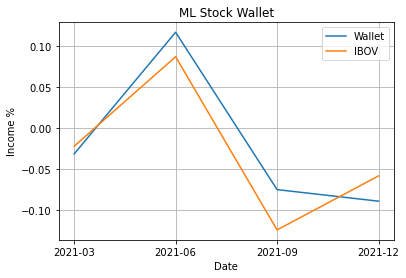

In [223]:
rends.sort(key = lambda x: x[0])

datas_plot = [val[0] for val in rends]
datas_plot = pd.Series(datas_plot).dt.strftime('%Y-%m')

wallet_plot = [val[1]-1 for val in rends]
ibov_plot = [val[2]-1 for val in rends]

fig, ax = plt.subplots()
ax.plot(datas_plot, wallet_plot, label="Wallet")
ax.plot(datas_plot, ibov_plot, label="IBOV")
ax.set(xlabel='Date',
       ylabel='Income %',
       title ='ML Stock Wallet')

plt.legend()
plt.grid()
plt.show()

From the graph above, we can see that our portfolio performed well, winning twice the stock market. We could look for different strategies to improve the performance of our portfolio, such as:

* Number of features selected using model performance.
* Search for the best features with model sensibility.
* Choose another model.
* Change the cutoff values used throughout this notebook to check its impact.

##### References

https://medium.com/swlh/teaching-a-machine-to-trade-stocks-like-warren-buffett-part-i-445849b208c6